# kNN & Clustering

__Суммарное количество баллов: 10 + 3 bonus__

## kNN, рак и спам

В этом части домашнего задания Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd

### Задание 1 (1 балл)

#### 1. (0.5 балла)
Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`.

In [14]:
CANCER_DATA_PATH = "hw2_data/cancer.csv"
SPAM_DATA_PATH = "hw2_data/spam.csv"

In [15]:
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    # raise NotImplementedError()
    df = pd.read_csv(path_to_csv, sep=",",  header = 0, decimal ='.')
    X = df[df.columns.difference(['label'])]
    y = df['label']
    return X, y

def read_spam_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    # raise NotImplementedError()
    df = pd.read_csv(path_to_csv, sep=",",  header = 0, decimal ='.')
    X = df[df.columns.difference(['label'])]
    y = df['label']
    return X, y

In [16]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
y_cancer = y_cancer.replace({'B':0, 'M':1})
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

#### 2. (0.5 балла) 

Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

In [54]:
def train_test_split(X, y, ratio):
    data_train = X.join(y)
    data_test = data_train.sample(frac=1 - ratio, random_state=239) # для сравнения результатов с коллегами

    data_train.drop(labels=data_test.index, inplace=True)
    data_train.reset_index(drop=True, inplace=True)
    data_test.reset_index(drop=True, inplace=True)

    y_train = data_train['label']
    y_test = data_test['label']

    X_train = data_train[data_train.columns.difference(['label'])] 
    X_test = data_test[data_test.columns.difference(['label'])]

    return X_train, y_train, X_test, y_test

### Задание 2 (1.5 балла)

Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [76]:
def get_precision_recall_accuracy(y_pred, y_true):
    accuracy =  (y_pred == y_true).sum() / len(y_pred)
    
    
    TP1 = np.array([0,0])
    FP1 = np.array([0,0])
    FN1 = np.array([0,0])
    
    y_pred = list(y_pred)
    y_true = list(y_true)
    
    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y_true[i] == 0:
            TP1[0] += 1
        if y_pred[i] == 1 and y_true[i] == 1:
            TP1[1] += 1
            
        if y_pred[i] == 0 and y_true[i] == 1:
            FP1[0] += 1
        if y_pred[i] == 1 and y_true[i] == 0:
            FP1[1] += 1
    
        if y_pred[i] == 1 and y_true[i] == 0:
            FN1[0] += 1
        if y_pred[i] == 0 and y_true[i] == 1:
            FN1[1] += 1
    
    # print(FN1, FN)
    FN = FN1
    FP = FP1
    TP = TP1
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    
    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [58]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [59]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 3  (3 балла)


## 1. (2 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево. (При желании можно воспользоваться библиотечной реализацией дерева)

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

In [60]:
from sklearn.neighbors import KDTree

In [97]:
class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size

    def fit(self, X, y):
        self.lab = y
        self.val = list(y.value_counts().index)
        self.len_val = len(list(y.value_counts().index))
        self.kdtree = KDTree(X, leaf_size=self.leaf_size)
    
    def predict_proba(self, X):
        zero = np.zeros((len(X), self.len_val))

        for l in range(zero.shape[0]):
            for i in range(self.len_val):
                zero[l,i] = (self.lab[self.kdtree.query(X, k=self.n_neighbors)[1][l]] == list(self.lab.value_counts().index)[i]).sum() / (self.n_neighbors) 
        return zero

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

Наконец, протестируем наш классификатор на различных наборах данных

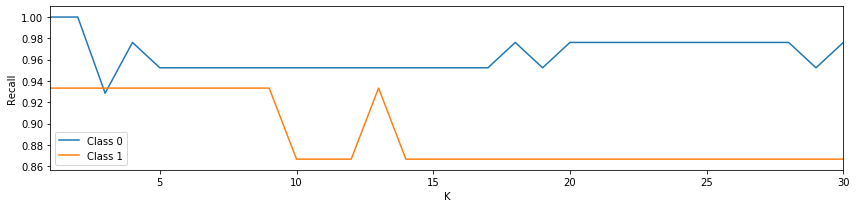

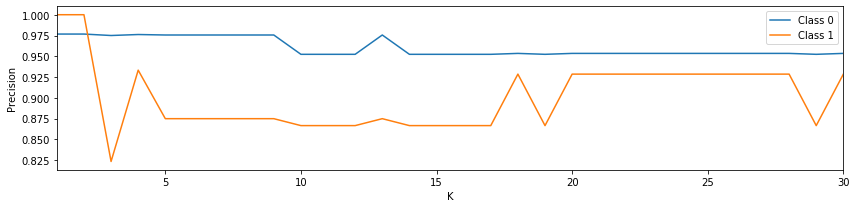

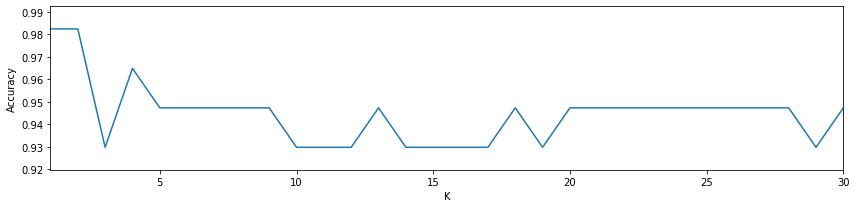

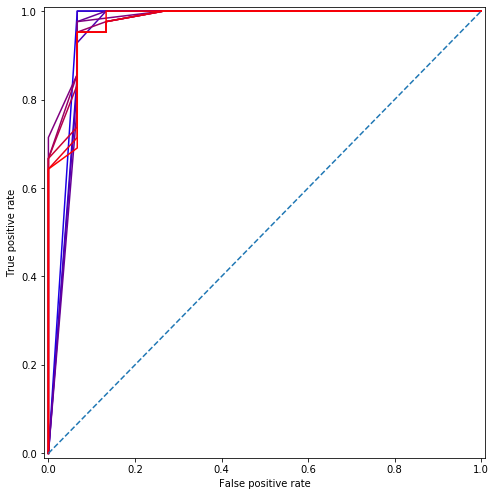

In [98]:
X_train, y_train, X_test, y_test = train_test_split(X_cancer, y_cancer, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

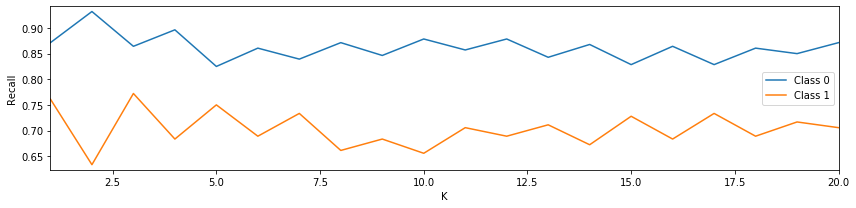

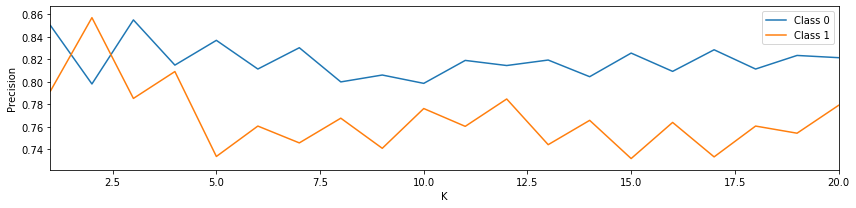

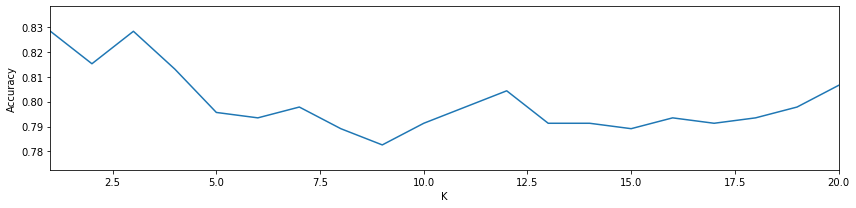

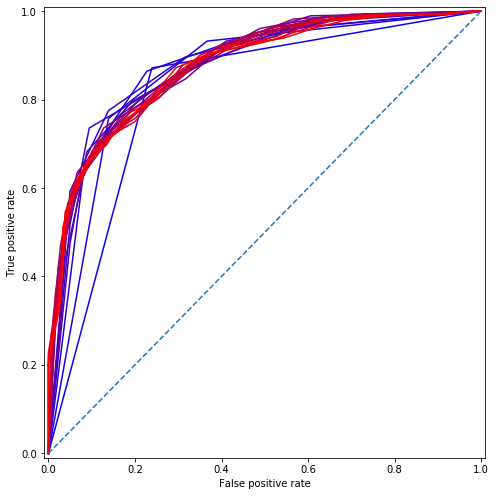

In [99]:
X_train, y_train, X_test, y_test = train_test_split(X_spam, y_spam, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)

#### 2. (1.5 балла)

Проанализируйте полученные графики. Какой параметр `k` кажется лучшим для каждой из задач? Какая из метрик лучше всего отражает качество модели? 

В первом случае нам важно, чтобы пациент больной раком был найден. То есть необходим большой recall. А согласно графикам k = 8 будет достаточно.  

Для второго случая - лучше иметь высокий presicion, так как нам нужно чтобы все важные письма были на месте. Как видно из графиков все средства хороши, но на мой субъективный взгляд лучше k = 7.

(Отмечу, что в первом случае пользовался графиками для метрик, во втором ROC кривой)

## Clustering

В этой части домашнего задания предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [100]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque

ModuleNotFoundError: No module named 'cv2'

In [104]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

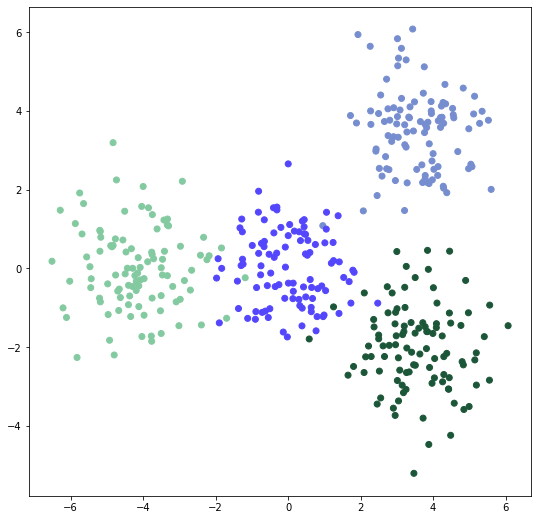

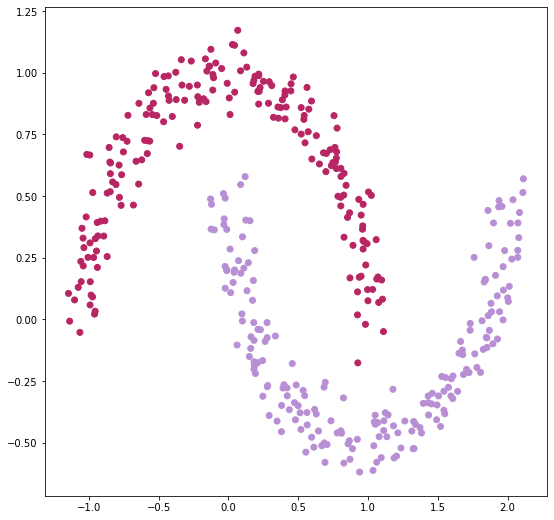

In [105]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 4 (1.5 балла)

Первый метод, который предлагается реализовать - метод K средних.

__Описание методов__

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

__Инициализация кластеров__

Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [ ]:
class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        raise NotImplementedError()
        
    def fit(self, X, y=None):
        raise NotImplementedError()
    
    def predict(self, X):
        raise NotImplementedError()

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 5 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Возможные метрики__

* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [199]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        

    def fit_predict(self, X, y=None):
        def find_other(tree, c, x, self, cluster, ch):
            for i in tree.query_radius([x], r=self.eps)[0]:
                if  cluster[i] == -1:
                    cluster[i] = c
                    if ch[i]:
                        find_other(tree, c, X[i], self, cluster, ch)
        
        minPts = self.min_samples
        eps = self.eps
        tree =  KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        
        what_is_your_cluster = [-1 for i in range(len(X))]
        check = [0 for i in range(len(X))]
        temp = 0
        for i in tree.query_radius(X, r=eps, count_only=True):
            if i >= minPts:
                check[temp] = 1
            temp += 1
        cluster_count = 0
        for i in range(len(X)):
            if check[i] == 1 and what_is_your_cluster[i] == -1:
                what_is_your_cluster[i] = cluster_count
                find_other(tree, cluster_count, X[i], self, what_is_your_cluster, check)
                cluster_count += 1 
        return what_is_your_cluster

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

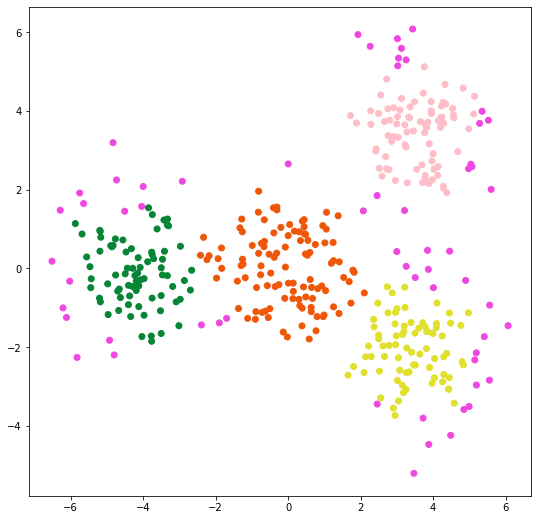

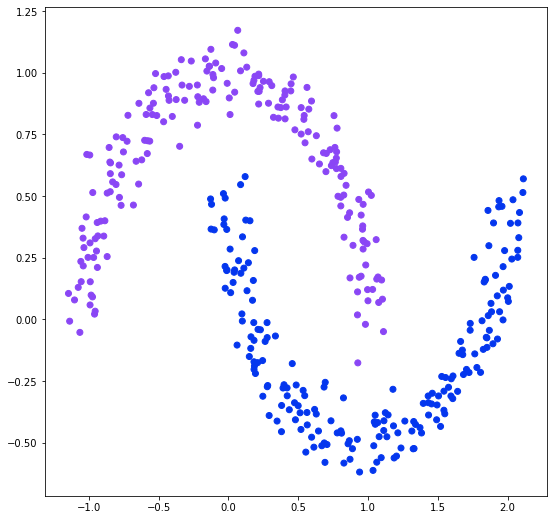

In [200]:
dbscan = DBScan(min_samples=10, eps=0.7)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 6 (0.5 балла)

Проанализируйте полученные результаты. 

Какой метод лучше справился с кластеризацией каждого из датасетов? Почему? 

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для определения качества кластеризации. 

Какие значения метрики свидетельствуют о хорошей кластеризации - большие или маленькие?

Silhouette score чем больше, тем лучше

Davies-Bouldin index чем меньше, тем лучше

(Я сделал только один способ кластеризации, но для него всё измерил)

In [197]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

In [198]:
dbscan_1 = DBScan(min_samples=10, eps=0.7)
labels_dbscan_1 = dbscan_1.fit_predict(X_1)

print(f'Значение метрики Силует (Silhouette) для первого варианта данных (4 явных кластера):{silhouette_score(X_1, labels_dbscan_1)}')
print(f'Значение метрики Давида-Болдуена (Davies-Bouldin) для первого варианта данных (4 явных кластера):{davies_bouldin_score(X_1, labels_dbscan_1)}')

dbscan = DBScan(eps=0.2)
labels = dbscan.fit_predict(X_2)

print(f'Значение метрики Силует (Silhouette) для второго варианта данных (2 явных кластера в виде бумерангов):{silhouette_score(X_2, labels)}')
print(f'Значение метрики Давида-Болдуена (Davies-Bouldin) для второго варианта данных (2 явных кластера в виде бумерангов):{silhouette_score(X_2, labels)}')
# print(silhouette_score(X_1, labels_dbscan_2))
# print(X_2, labels)

Значение метрики Силует (Silhouette) для первого варианта данных (4 явных кластера):0.4244409859875994
Значение метрики Давида-Болдуена (Davies-Bouldin) для первого варианта данных (4 явных кластера):2.619905317549124
Значение метрики Силует (Silhouette) для второго варианта данных (2 явных кластера в виде бумерангов):0.3220921026847154
Значение метрики Давида-Болдуена (Davies-Bouldin) для второго варианта данных (2 явных кластера в виде бумерангов):0.3220921026847154


### Bonus. (3 балла)

#### 1. (2.5 балла)

Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Linkage-функции__

__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [18]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        raise NotImplementedError()
    
    def fit_predict(self, X, y=None):
        raise NotImplementedError()

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

In [ ]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

#### 2. (0.5 балла)

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для `AgglomertiveClustering` с `K-means` и `DBSCAN`. 

Какой из методов лучше произвел кластеризацию данных?

_Ваш ответ_

In [21]:
# YOUR_CODE